# Mesh creation in serial and parallel
Author: Jørgen S. Dokken

In this tutorial we will consider the first important class in DOLFINx, the `dolfinx.mesh.Mesh` class.

A mesh consists of a set of cells. These cells can be intervals, triangles, quadrilaterals, hexahedrons or tetrahedrons.
Each cell is described by a set of coordinates, and its connectivity.

## Mesh creation from numpy arrays
For instance, let us consider a unit square. If we want to discretize it with triangular elements, we could create the set of vertices as a $(4\times 2)$ numpy array

In [1]:
import numpy as np
tri_points = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=np.float64)

Next, we have to decide on how we want to create the two triangles in the mesh. Let's choose the first cell to consist of vertices $0,1,3$ and the second cell consist of vertices $0,2,3$

In [2]:
triangles = np.array([[0,1,3], [0,2,3]], dtype=np.int64)

We note that for triangular cells, we could order the vertices in any order say `[[1,3,0],[2,0,3]]`, and the mesh would equivalent.
Some finite element software reorder cells to ensure consistent integrals over interior facets.
In DOLFINx, another strategy has been chosen, see {cite}`10.1145/3524456` for more details.

Let's consider the unit square again, but this time we want to discretize it with two quadrilateral cells.

In [3]:
quad_points = np.array([[0,0],[0.3, 0], [1, 0], [0, 1], [0.5, 1], [1, 1]], dtype=np.float64)
quadrilaterals = np.array([[0, 1, 3, 4], [1, 2, 4, 5]], dtype=np.int64)

Note that we do not parse the quadrilateral cell in a clockwise or counter-clockwise fashion.
Instead, we are using a tensor product ordering.
The ordering of the sub entities all cell types used in DOLFINx can be found at [Basix supported elements](https://github.com/FEniCS/basix/#supported-elements).
We also note that this unit square mesh has non-affine elements.

Next, we would like to generate the mesh used in DOLFINx.
To do so, we need to generate the coordinate element.
This is the paramterization of each an every element, and the only way of going between the physical element and the reference element.
We will denote any coordinate on the reference element as $\mathbf{X}$,
and any coordinate in the physical element as $\mathbf{x}$,
with the mapping $M$ such that $\mathbf{x} = M(\mathbf{X})$.

We can write 

$$
\begin{align}
M(\mathbf{X})= \sum_{i=0}^{\text{num vertices}} \mathbf{v}_i\phi_i(\mathbf{X}
\end{align})
$$

where $\mathbf{v}_i$ is the $i$th vertex of a cell and $\phi_i$ are the basis functions specifed at [DefElement P1 triangles](https://defelement.com/elements/examples/triangle-Lagrange-1.html) and
[DefElement Q1 quadrilaterals](https://defelement.com/elements/examples/quadrilateral-Q-1.html).

In DOLFINx we use the [Unified Form Language](https://github.com/FEniCS/ufl/) to define finite elements.
Therefore we create the `ufl.Mesh`

In [4]:
import ufl
ufl_tri = ufl.Mesh(ufl.VectorElement("Lagrange", ufl.triangle, 1))
ufl_quad = ufl.Mesh(ufl.VectorElement("Lagrange", ufl.quadrilateral, 1))

This is all the input we need to a DOLFINx mesh

In [5]:
import dolfinx
from mpi4py import MPI

quad_mesh = dolfinx.mesh.create_mesh(
    MPI.COMM_WORLD, quadrilaterals, quad_points, ufl_quad)
tri_mesh = dolfinx.mesh.create_mesh(
    MPI.COMM_WORLD, triangles, tri_points, ufl_tri)

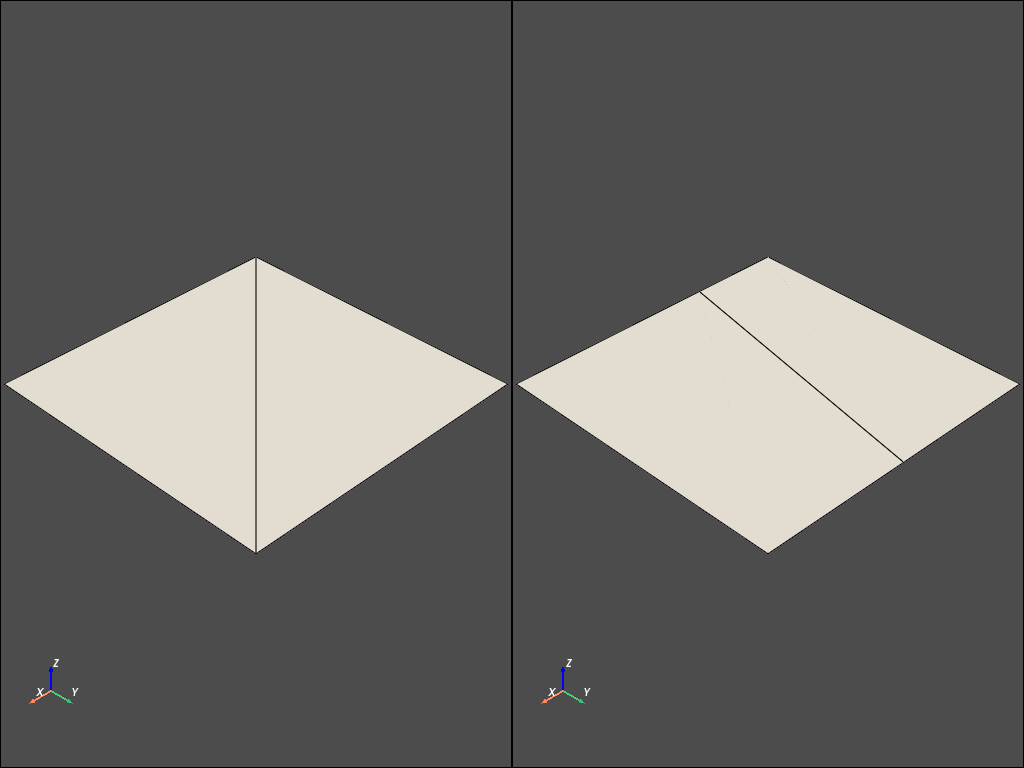

In [6]:
import pyvista
pyvista.start_xvfb(1)
plotter = pyvista.Plotter(shape=(1, 2))
plotter.subplot(0, 0)
_tri = pyvista.UnstructuredGrid(*dolfinx.plot.create_vtk_mesh(tri_mesh))
plotter.add_mesh(_tri, show_edges=True)
plotter.show_axes()
_quad= pyvista.UnstructuredGrid(*dolfinx.plot.create_vtk_mesh(quad_mesh))
plotter.subplot(0, 1)
plotter.show_axes()
plotter.add_mesh(_quad, show_edges=True)
plotter.show()

The only input to this function we have not covered so far is the `MPI.COMM_WORLD`, which is an MPI communicator.

### MPI Communication
When we run a python code with `python3 name_of_file.py`. We execute python on a single process on the computer. However, if we launch the code with `mpirun -n N python3 name_of_file.py`, we execute the code on `N` processes at the same time. The `MPI.COMM_WORLD` is the communicator among the `N` processes, which can be used to send and receive data. If we use `MPI.COMM_SELF`, the communicator will not communicate with other processes.
When we run in serial, `MPI.COMM_WORLD` is equivalent to `MPI.COMM_SELF`.

Two important values in the MPI-communicator is its `rank` and `size`.
If we run this in serial on either of the communicators above, we get


In [7]:
print(f"{MPI.COMM_WORLD.rank=} {MPI.COMM_WORLD.size=}")
print(f"{MPI.COMM_SELF.rank=} {MPI.COMM_SELF.size=}")

MPI.COMM_WORLD.rank=0 MPI.COMM_WORLD.size=1
MPI.COMM_SELF.rank=0 MPI.COMM_SELF.size=1


In jupyter noteboooks, we use [ipyparallel](https://ipyparallel.readthedocs.io/en/latest/) to start a cluster and connect to two processes, which we can execute commands on using the magic `%%px` at the top of each cell. See [%%px Cell magic](https://ipyparallel.readthedocs.io/en/latest/tutorial/magics.html#px-cell-magic) for more details.

```{note}
When starting a cluster, we do not carry ower any modules or variables from the previously executed code in the script.
```

In [8]:
import ipyparallel as ipp
cluster = ipp.Cluster(engines="mpi", n=2)
rc = cluster.start_and_connect_sync()

Starting 2 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


INFO:ipyparallel.cluster.cluster.1679244433-r03j:Starting 2 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/2 [00:00<?, ?engine/s]

Next, we import `mpi4py` on the two engines and check the rank and size of the two processes.

In [9]:
%%px
from mpi4py import MPI as MPIpx
import numpy as np
import ufl
import dolfinx

print(f"{MPIpx.COMM_WORLD.rank=} {MPIpx.COMM_WORLD.size=}")

[stdout:1] MPIpx.COMM_WORLD.rank=1 MPIpx.COMM_WORLD.size=2


[stdout:0] MPIpx.COMM_WORLD.rank=0 MPIpx.COMM_WORLD.size=2


Next, we want to create the triangle mesh, distributed over the two processes.
We do this by sending in the points and cells for the mesh in one of two ways:

**1. Send all points and cells on one process**

In [10]:
%%px
if MPIpx.COMM_WORLD.rank == 0:
    tri_points = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=np.float64)
    triangles = np.array([[0,1,3], [0,2,3]], dtype=np.int64)
else:
    tri_points = np.empty((0,2), dtype=np.float64)
    triangles = np.empty((0,3), dtype=np.int64)
ufl_tri = ufl.Mesh(ufl.VectorElement("Lagrange", ufl.triangle, 1))
tri_mesh = dolfinx.mesh.create_mesh(
    MPIpx.COMM_WORLD, triangles, tri_points, ufl_tri)
cell_index_map = tri_mesh.topology.index_map(tri_mesh.topology.dim)
print(f"Num cells local: {cell_index_map.size_local}\n Num cells global: {cell_index_map.size_global}")

[stdout:1] Num cells local: 1
 Num cells global: 2


[stdout:0] Num cells local: 1
 Num cells global: 2


In [37]:
%%px
import pyvista
pyvista.start_xvfb(1)
def plot_mesh(mesh):
    plotter = pyvista.Plotter(window_size=(500,500))
    _mesh = pyvista.UnstructuredGrid(*dolfinx.plot.create_vtk_mesh(mesh))
    #cell_labels = [f'Cell {i}' for i in range(_mesh.n_cells)]
    #plotter.add_point_labels(_mesh.cell_centers(), cell_labels, font_size=25)
    if _mesh.n_cells > 0:
        plotter.add_mesh(_mesh, show_edges=True)
        plotter.add_title(f"Rank: {mesh.comm.rank}")
        plotter.show_axes()
        plotter.show()

[output:1]

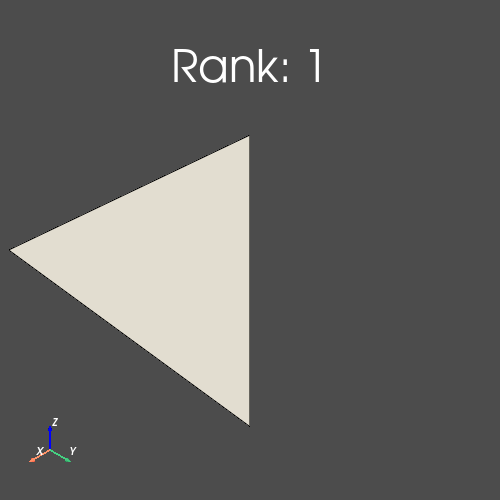

[output:0]

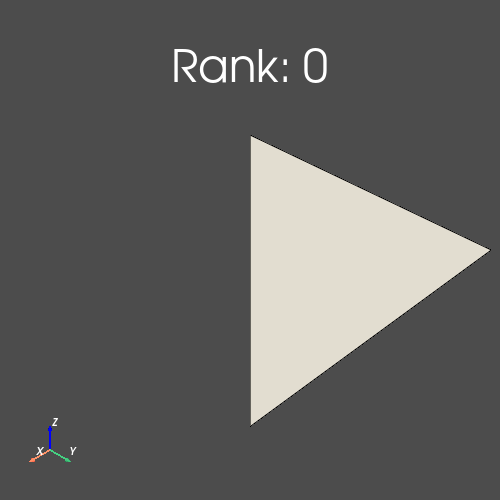

In [38]:
%%px
plot_mesh(tri_mesh)

From the output above, we see the distribution of cells on each process.

**2. Distribute input of points and cells**

For large meshes, reading in all points and cells on a single process would be a bottle-neck.
Therefore, we can read in the points and cells in a distributed fashion.
Note that if we do this it important to note that it is assumed that rank 0 has read in the first chunck of points and cells in a continuous fashion. 

In [39]:
%%px
if MPIpx.COMM_WORLD.rank == 0:
    quadrilaterals = np.array([], dtype=np.int64)
    quad_points = np.array([[0,0],[0.3, 0]], dtype=np.float64)
elif MPIpx.COMM_WORLD.rank == 1:
    quadrilaterals = np.array([[0, 1, 3, 4], [1, 2, 4, 5]], dtype=np.int64)
    quad_points = np.array([[1, 0], [0, 1], [0.5, 1], [1, 1]], dtype=np.float64)
else:
    quad_points = np.empty((0,2), dtype=np.float64)
    quadrilaterals = np.empty((0,4), dtype=np.int64)

ufl_quad = ufl.Mesh(ufl.VectorElement("Lagrange", ufl.quadrilateral, 1))
quad_mesh = dolfinx.mesh.create_mesh(
    MPIpx.COMM_WORLD, quadrilaterals, quad_points, ufl_quad)
cell_index_map = quad_mesh.topology.index_map(quad_mesh.topology.dim)
print(f"Num cells local: {cell_index_map.size_local}\n Num cells global: {cell_index_map.size_global}")

[stdout:1] Num cells local: 1
 Num cells global: 2


[stdout:0] Num cells local: 1
 Num cells global: 2


[output:1]

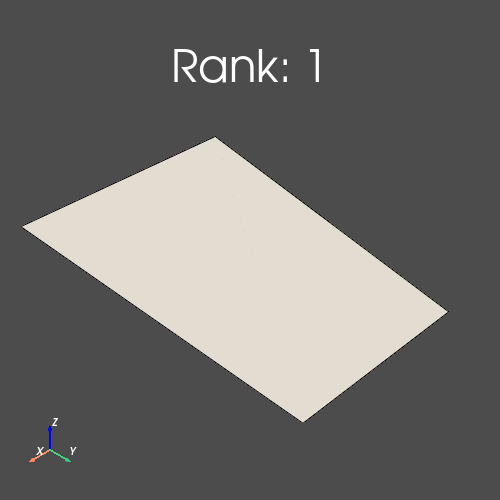

[output:0]

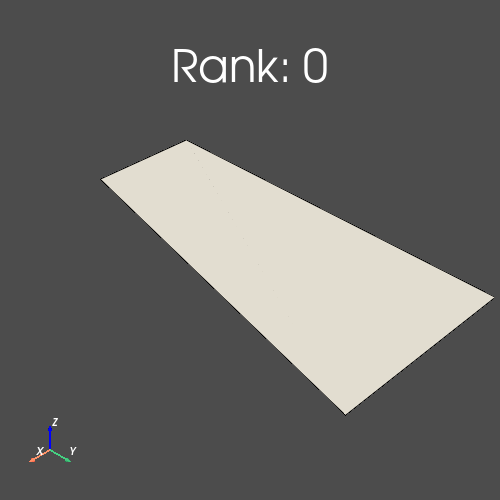

In [40]:
%%px
plot_mesh(quad_mesh)

### Usage of MPI.COMM_SELF
You might wonder, if we can use multiple processes, when would we ever use `MPI.COMM_SELF`?
There are many reasons for this. For instance, many simulations are too small to gain from parallelizing.
Then one could use `MPI.COMM_SELF` with multiple processes to run parameterized studies in parallel

In [41]:
%%px
serial_points = np.array([[0,0],[0.3, 0], [1, 0], [0, 1], [0.5, 1], [1, 1]], dtype=np.float64)
serial_quads = np.array([[0, 1, 3, 4], [1, 2, 4, 5]], dtype=np.int64)
serial_mesh = dolfinx.mesh.create_mesh(
    MPIpx.COMM_SELF, serial_quads, serial_points, ufl_quad)
cell_index_map = serial_mesh.topology.index_map(serial_mesh.topology.dim)
print(f"Num cells local: {cell_index_map.size_local}\n Num cells global: {cell_index_map.size_global}")

[stdout:1] Num cells local: 2
 Num cells global: 2


[stdout:0] Num cells local: 2
 Num cells global: 2


[output:0]

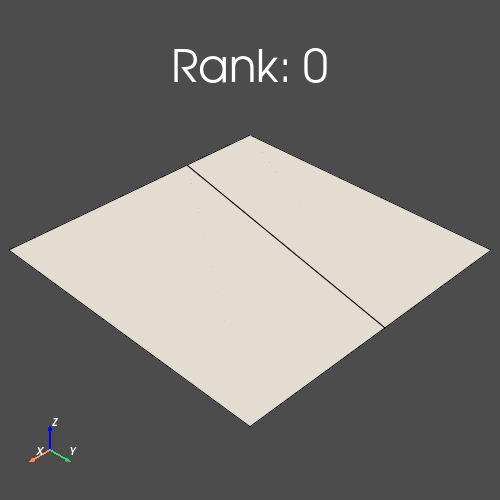

[output:1]

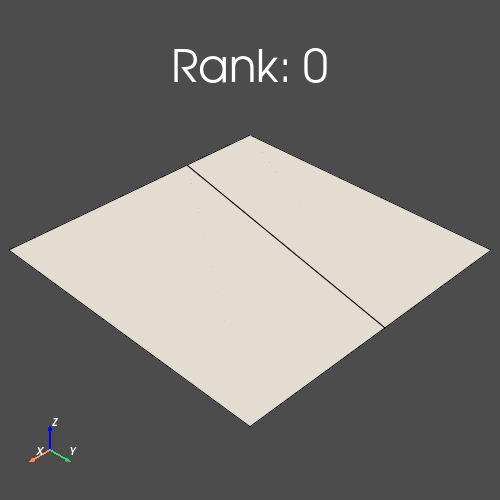

In [42]:
%%px
plot_mesh(serial_mesh)

## Mesh-partitioning
As we have seen above, we can send in data to mesh creation and get either a distributed mesh out, but how does it work?
Under the hood, what happens is that DOLFINx calls a graph-partitioning algorithm.
This algorithm is supplied from either from PT-Scotch{cite}`10.1016/j.parco.2007.12.001`, ParMETIS{cite}`10.1145/369028.369103` or KaHIP{cite}`10.1007/978-3-642-38527-8_16`, depending on what is available with your installation.

We can list the available partitioners with the following code:

In [43]:
%%px
try:
    from dolfinx.graph import partitioner_scotch
    has_scotch = True
except ImportError:
    has_scotch = False
try:
    from dolfinx.graph import partitioner_kahip
    has_kahip = True
except ImportError:
    has_kahip = False
try:
    from dolfinx.graph import partitioner_parmetis
    has_parmetis = True
except ImportError:
    has_parmetis = False
print(f"{has_scotch=}  {has_kahip=} {has_parmetis=}")

[stdout:1] has_scotch=True  has_kahip=False has_parmetis=False


[stdout:0] has_scotch=True  has_kahip=False has_parmetis=False


Given any of these partitioners (we will from now on use Scotch), you can send them into create mesh by calling

In [44]:
%%px
assert has_scotch
partitioner = dolfinx.mesh.create_cell_partitioner(partitioner_scotch())
quad_mesh = dolfinx.mesh.create_mesh(
    MPIpx.COMM_WORLD, quadrilaterals, quad_points, ufl_quad, partitioner=partitioner)

[output:0]

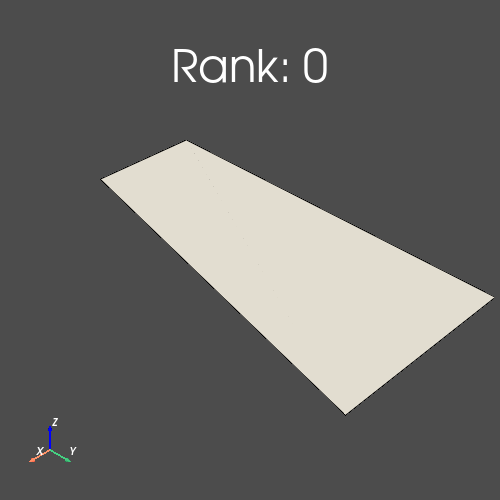

[output:1]

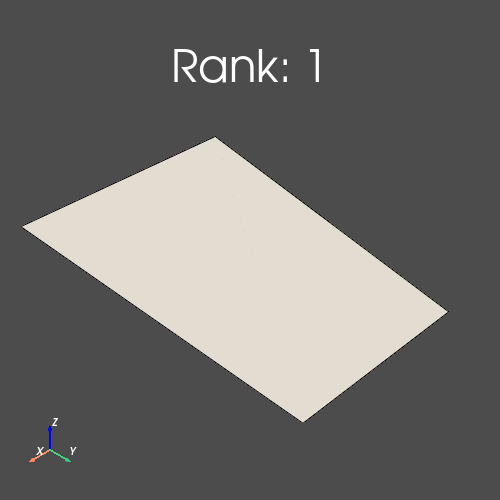

In [45]:
%%px
plot_mesh(quad_mesh)

## Custom partitioning
In some cases, one would like to use a specific partitioning. This might be because one have already partitioned the mesh, and when reading it in, one would like to keep this partitioning. We can achieve this by creating a custom partitioner.

In [46]:
%%px

def custom_partitioner(comm: MPIpx.Intracomm, n, m, topo):
    dests = np.full(topo.num_nodes, comm.rank, dtype=np.int32)
    offsets = np.arange(topo.num_nodes+1, dtype=np.int32)
    return dolfinx.graph.create_adjacencylist(dests, offsets)

custom_mesh = dolfinx.mesh.create_mesh(
    MPIpx.COMM_WORLD, quadrilaterals, quad_points, ufl_quad, partitioner=custom_partitioner)
num_cells_local = custom_mesh.topology.index_map(2).size_local
num_cells_global = custom_mesh.topology.index_map(2).size_global
print(f"Rank: {MPIpx.COMM_WORLD.rank}: {num_cells_local=} {num_cells_global=} (Num input cells: {quadrilaterals.shape[0]})")

[stdout:1] Rank: 1: num_cells_local=2 num_cells_global=2 (Num input cells: 2)


[stdout:0] Rank: 0: num_cells_local=0 num_cells_global=2 (Num input cells: 0)


[output:1]

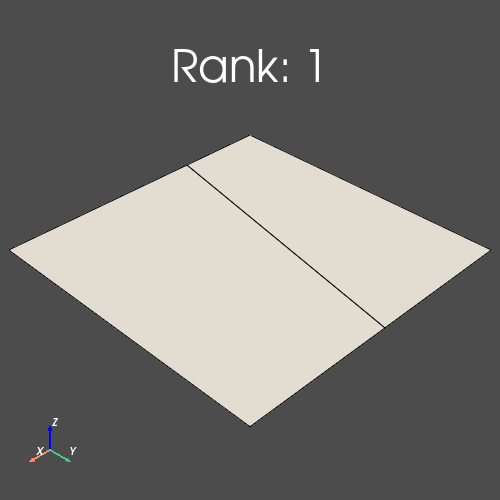

In [47]:
%%px
plot_mesh(custom_mesh)

## Ghosting
If one wants to use Discontinuous Galerkin methods, one needs extra information in parallel. 
To be able to compute interior integrals, every interior facet owned by a process needs to have access to the two cells its connected to.
To be able to control this, one can send in `ghost_mode=dolfinx.mesh.GhostMode.shared_facet` to the mesh creation algorithm.
We start by inspecting the previously created methods

In [48]:
%%px
print(f"Number of ghost cells: {cell_index_map.num_ghosts}")

[stdout:0] Number of ghost cells: 0


[stdout:1] Number of ghost cells: 0


Thus, we observe that we only have cells owned by the process on each rank. By adding ghost mode to the mesh creation:

In [49]:
%%px
shared_partitioner = dolfinx.mesh.create_cell_partitioner(dolfinx.mesh.GhostMode.shared_facet)
ghosted_mesh = dolfinx.mesh.create_mesh(
    MPIpx.COMM_WORLD, quadrilaterals, quad_points, ufl_quad, partitioner=shared_partitioner)
num_cells_local = ghosted_mesh.topology.index_map(ghosted_mesh.topology.dim).size_local
num_ghosts = ghosted_mesh.topology.index_map(ghosted_mesh.topology.dim).num_ghosts
print(f"{MPIpx.COMM_WORLD.rank}: {num_cells_local=} {num_ghosts=}")

[stdout:0] 0: num_cells_local=1 num_ghosts=1


[stdout:1] 1: num_cells_local=1 num_ghosts=1


## References
```{bibliography}
:filter: docname in docnames
```
